# Predicting Heart Disease Using Classification
#### Group 11: Cameron Geisler, Daisy Liu, Nima Zareian, Sean Chung
## Introduction
This project will use [Heart Disease Dataset](https://archive.ics.uci.edu/ml/datasets/Heart+Disease), which describes the various attributes, symptoms and observations seen on patients in the process of being diagnosed with cardiovascular diseases. 
<br> <br>
Specifically, the project will be using a [processed version](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data) of said data containing information documented by the Cleveland Foundation, which is the most complete out of all given options.
<br> <br>
Diagnosis for cardiovascular diseases are often based on direct examinations of the heart done through the use of electrocardiograms (measures heart beat rhythms) and echocardiograms (measures the heart's physical state with ultrasound).
<br> <br>
Aside from these direct testing methods, there are other health metrics which can be used to help predict heart disease. Incidentally, almost half of all heart attacks experienced by people were unanticipated due to the presence of asymptomatic heart diseases, that is, heart diseases with little to no experience based indicators, and are thus difficult to notice and diagnose.

<b>Predictive question:</b> Given easily measured health indicators, such as age and maximum heart rate, what is the status of patients' heart disease (present/absent)?
<br><br>


## Methods

First, we load the necessary packages.

In [2]:
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(tidymodels)))
suppressWarnings(suppressMessages(library(repr)))
suppressWarnings(suppressMessages(library(GGally)))
options(repr.matrix.max.rows = 6)

Next, we load the dataset from the [URL](https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data).

In [3]:
# Load the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names <- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num")
data_raw <- read_csv(url, col_names = names)

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_character(),
  thal = col_character(),
  num = col_double()
)



The data is already in a tidy format. However, we will make some small changes such as making the column names more descriptive and human readable, and converting the columns to the correct data type. In this analysis we will use the variables: age (years), resting blood pressure (mmHg), cholesterol level (mg/dL), and heart rate (bpm) to predict the presence of heart disease in a patient.

In [4]:
# Wrangle data
heart_data <- data_raw %>%
    select(c("age", "thalach", "num")) %>% # select only columns that are used
    mutate(num = as_factor(num)) %>% # update target variables to factor
    rename(heart_disease = num, # rename columns with more intuitive names
          max_heart_rate = thalach)

In the original data, there are five levels of heart disease (labelled 0, 1, 2, 3, 4), which varying degrees of disease, from "no visible heart disease" to "very severe heart disease". We combine levels 1-4, in order to simply classify the observations as having heart diesease (labelled as "Yes") or not (labelled as "No").

In [5]:
heart_data <- heart_data %>%
    mutate(heart_disease = as_factor(ifelse(heart_disease == 0, "No", "Yes")))
head(heart_data)

age,max_heart_rate,heart_disease
<dbl>,<dbl>,<fct>
63,150,No
67,108,Yes
67,129,Yes
37,187,No
41,172,No
56,178,No


Here, we split the data into training and testing set. The training set will be used to train the K-nearest neighbors model, and the final model's accuracy will be measured by applying it to the testing set.

In [6]:
set.seed(1) # set the seed

heart_split = initial_split(heart_data, prop = 0.75, strata = heart_disease)
heart_training = training(heart_split)
heart_testing = testing(heart_split)

Below we can see that the training and testing datasets are stratified since they have almost identical ratio of observations with and without heart disease. This is important as it allows us to have equal representation of both types of observations in our training and testing dataset.

In [7]:
# Training dataset summary
heart_training %>%
    group_by(heart_disease) %>%
    summarize(n = n(), .groups = "drop") %>%
    mutate(percent = n / nrow(heart_training))

heart_disease,n,percent
<fct>,<int>,<dbl>
No,123,0.5394737
Yes,105,0.4605263


In [8]:
# Testing dataset summary
heart_testing %>%
    group_by(heart_disease) %>%
    summarize(n = n(), .groups = "drop") %>%
    mutate(percent = n / nrow(heart_testing))

heart_disease,n,percent
<fct>,<int>,<dbl>
No,41,0.5466667
Yes,34,0.4533333


Figure 1 shows the relative proportion of individuals with and without heart disease in the data set. Notice that the proportions are roughly equal in each category, as a result, we do not need to balance our dataset as there is a fair representation of both observations.
> Could combine this with the outputs above which also show us the precentage.

> Should we balance our dataset? is 45% to 55% "balance enough"?

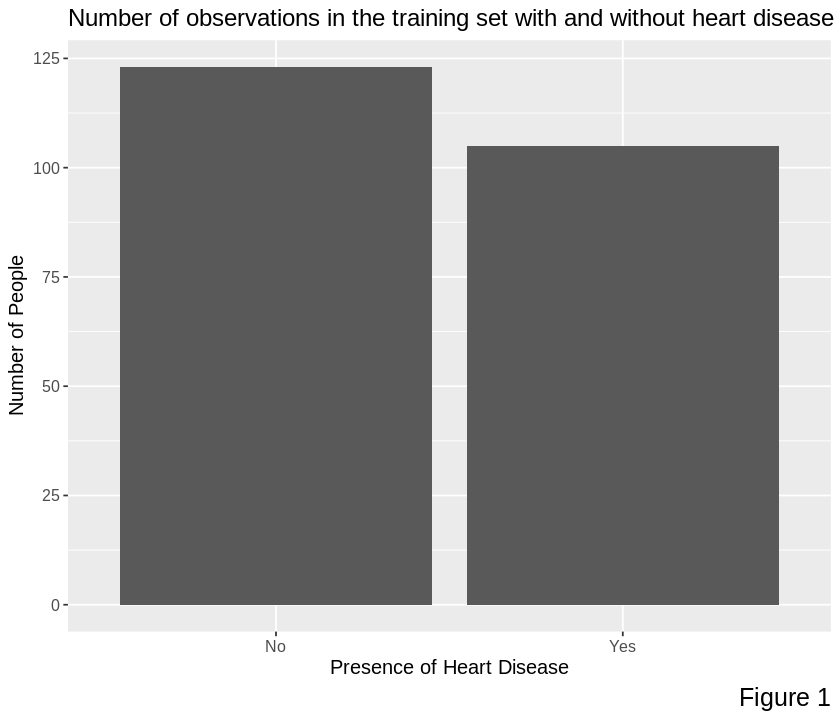

In [9]:
options(repr.plot.width = 7, repr.plot.height = 6)

ggplot(heart_training, aes(x = heart_disease)) +
    geom_bar() +
    xlab("Presence of Heart Disease") +
    ylab("Number of People") +
    ggtitle("Number of observations in the training set with and without heart disease") + 
    labs(caption = "Figure 1") + 
    theme(
      text = element_text(size = 12),
      plot.caption = element_text(size = 15)
    )

Below are histograms for the predictor variables, as well as a scatterplot for the two variables. The graphs are split into people that have heart disease (in blue) and those who don't (in red). Looking at the histograms, it seems that age is positively associated with heart disease, and maximum heart rate is negatively associated with heart disease.

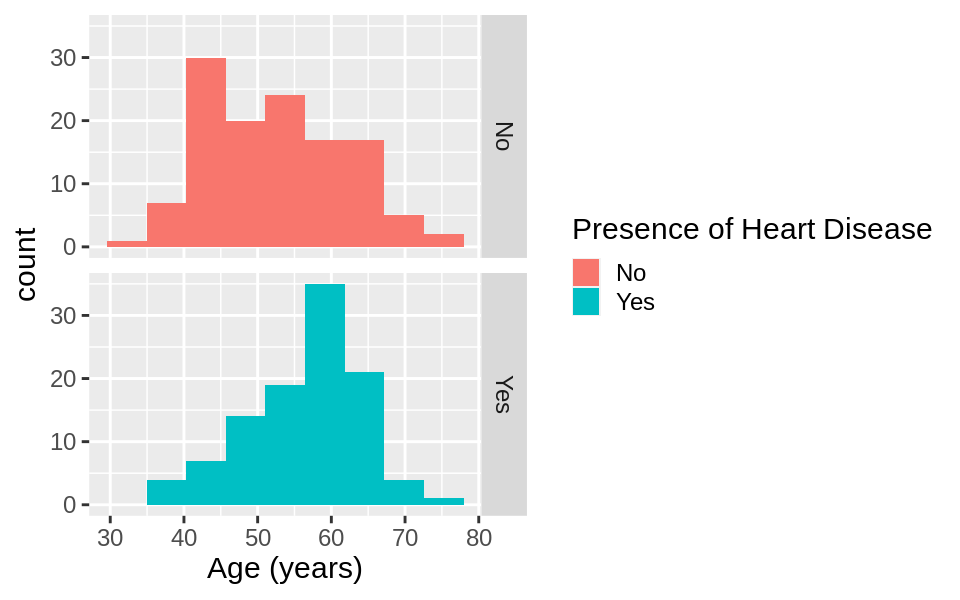

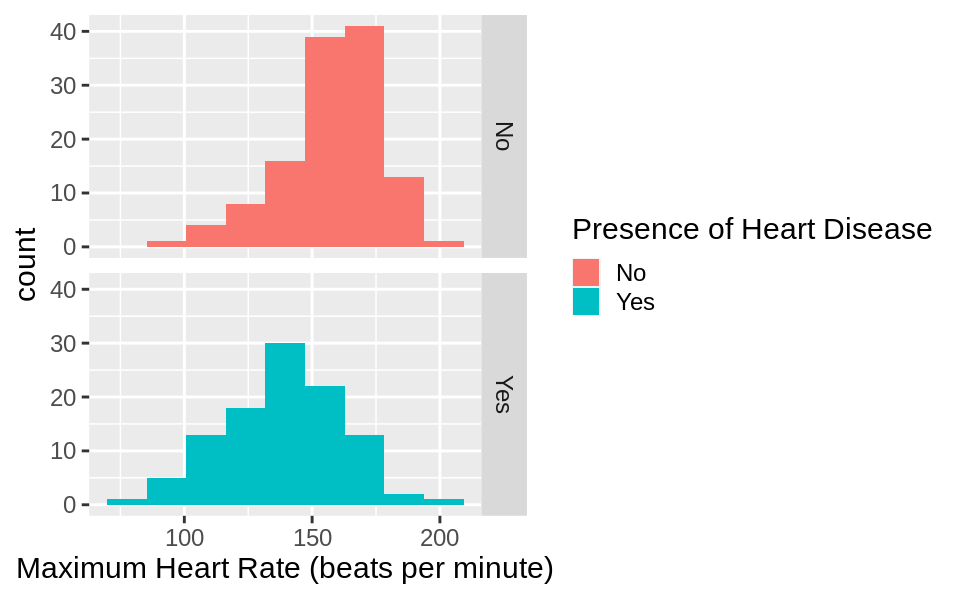

In [10]:
options(repr.plot.width = 8, repr.plot.height = 5)
theme_set(theme_gray(base_size = 18))
bins_num = ceiling(log(nrow(heart_training),2))+1 # number of bins, by Sturges' formula

# Histograms for predictor variables
# ggpairs(heart_training, mapping = aes(color = heart_disease), columns = 1:2)
ggplot(heart_training, aes(x = age, fill = heart_disease)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = heart_training$heart_disease) + 
    labs(x = "Age (years)", fill = "Presence of Heart Disease")
ggplot(heart_training, aes(x = max_heart_rate, fill = heart_disease)) +
    geom_histogram(bins = bins_num) +
    facet_grid(rows = heart_training$heart_disease) + 
    labs(x = "Maximum Heart Rate (beats per minute)", fill = "Presence of Heart Disease")

Below is a scatterplot, which combines the two variables, and the points are again colored using the presence of heart disease. Looking at the scatterplot, the blue points are clustered more towards the bottom half, and the red points are clusterd more towards the top-left corner.

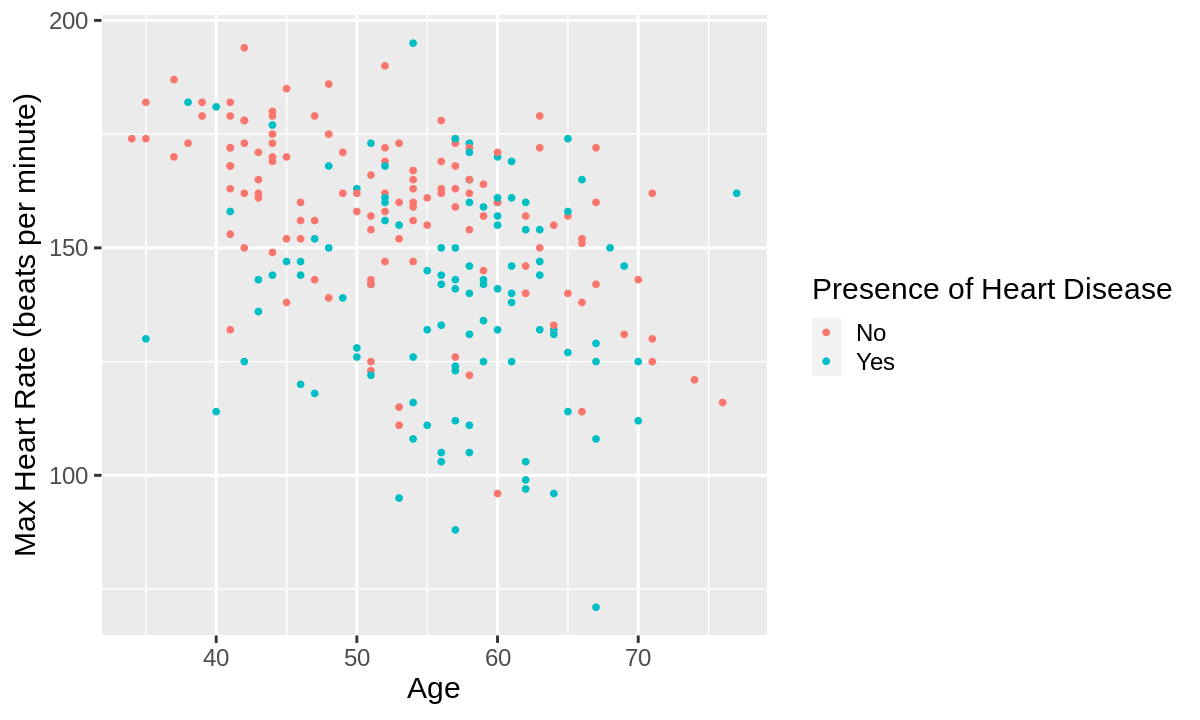

In [11]:
# Scatterplot
options(repr.plot.width = 10, repr.plot.height = 6)
ggplot(heart_training, aes(x = age, y = max_heart_rate, color = heart_disease)) + 
    geom_point() + 
    labs(x = "Age", y = "Max Heart Rate (beats per minute)", color = "Presence of Heart Disease")

## K-NN Data Analysis

We use K-nearest neighbors classification, with predictor variables of age and maximum heart rate, and target variable of the diagnosis of heart disease. Using the training set, we further split the data set to perform cross-validation.

In [12]:
# Create a K-Nearest neighbor model for the training set
recipe <- recipe(heart_disease ~ age + max_heart_rate, data = heart_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())

spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
         set_engine("kknn") %>%
         set_mode("classification")

In [13]:
# Find K with max accuracy
vfold <- vfold_cv(heart_training, v = 5, strata = heart_disease)
k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))

knn_result <- workflow() %>% 
          add_recipe(recipe) %>%
          add_model(spec) %>%
          tune_grid(resamples = vfold, grid = k_vals) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy")

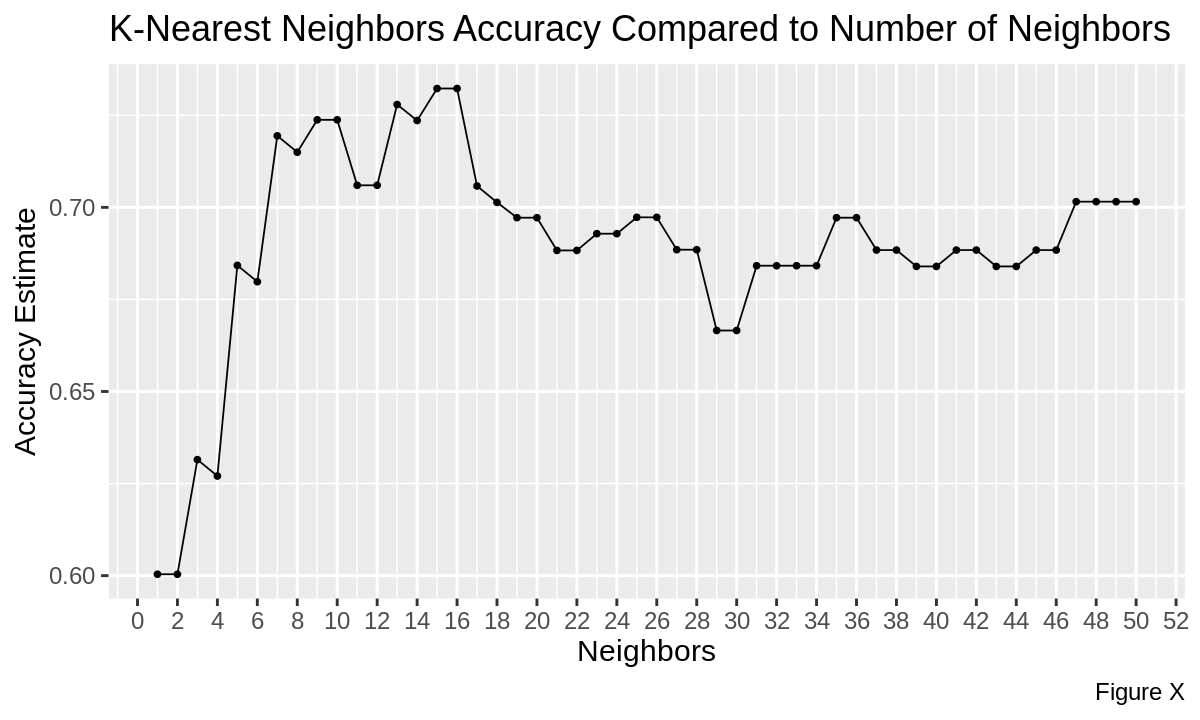

In [14]:
options(repr.plot.width = 10, repr.plot.height = 6)

accuracy_vs_k <- ggplot(knn_result, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() + 
    labs(x = "Neighbors", y = "Accuracy Estimate", caption = "Figure X") +   
    ggtitle("K-Nearest Neighbors Accuracy Compared to Number of Neighbors") +
    scale_x_continuous(breaks = scales::pretty_breaks(n = 20))
accuracy_vs_k

Here, we find the maximum estimated accuracy is with $k = 15$.

In [15]:
max_accuracy <- knn_result %>%
  filter(mean == max(mean))
max_accuracy

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
15,accuracy,binary,0.7322705,5,0.04272793,Model15
16,accuracy,binary,0.7322705,5,0.04272793,Model16


In [16]:
# Train model with actual K
k_max <- 15
actual_spec <- nearest_neighbor(weight_func = "rectangular", 
                                    neighbors = k_max) %>%
                                    set_engine("kknn") %>%
                                    set_mode("classification")

knn_fit <- workflow() %>%
       add_recipe(recipe) %>%  
       add_model(actual_spec) %>% 
       fit(data = heart_training)

# Results

Here, we use the model to make predictions on the testing set. The overall accuracy (the proportion of correct predictions) is about 73%.

In [17]:
# Predictions and accuracy
predictions <- predict(knn_fit, heart_testing) %>% 
               bind_cols(heart_testing)

accuracy <- predictions %>%
            metrics(truth = heart_disease, estimate = .pred_class) %>%
            filter(.metric == "accuracy") %>%
            select(.estimate) %>%
            pull()
accuracy

[1] 0.7333333

Next, we create a confusion matrix. Notice that the false positive rate is $11/41 \approx 27\%$, and the false negative rate is $9/34 \approx 26\%$.

In [18]:
# Confusion matrix for predictions
conf_mat <- predictions %>%
    conf_mat(truth = heart_disease, estimate = .pred_class)
conf_mat

          Truth
Prediction No Yes
       No  30   9
       Yes 11  25

Finally, we can make a predictions plot, to see any general trends in the model.

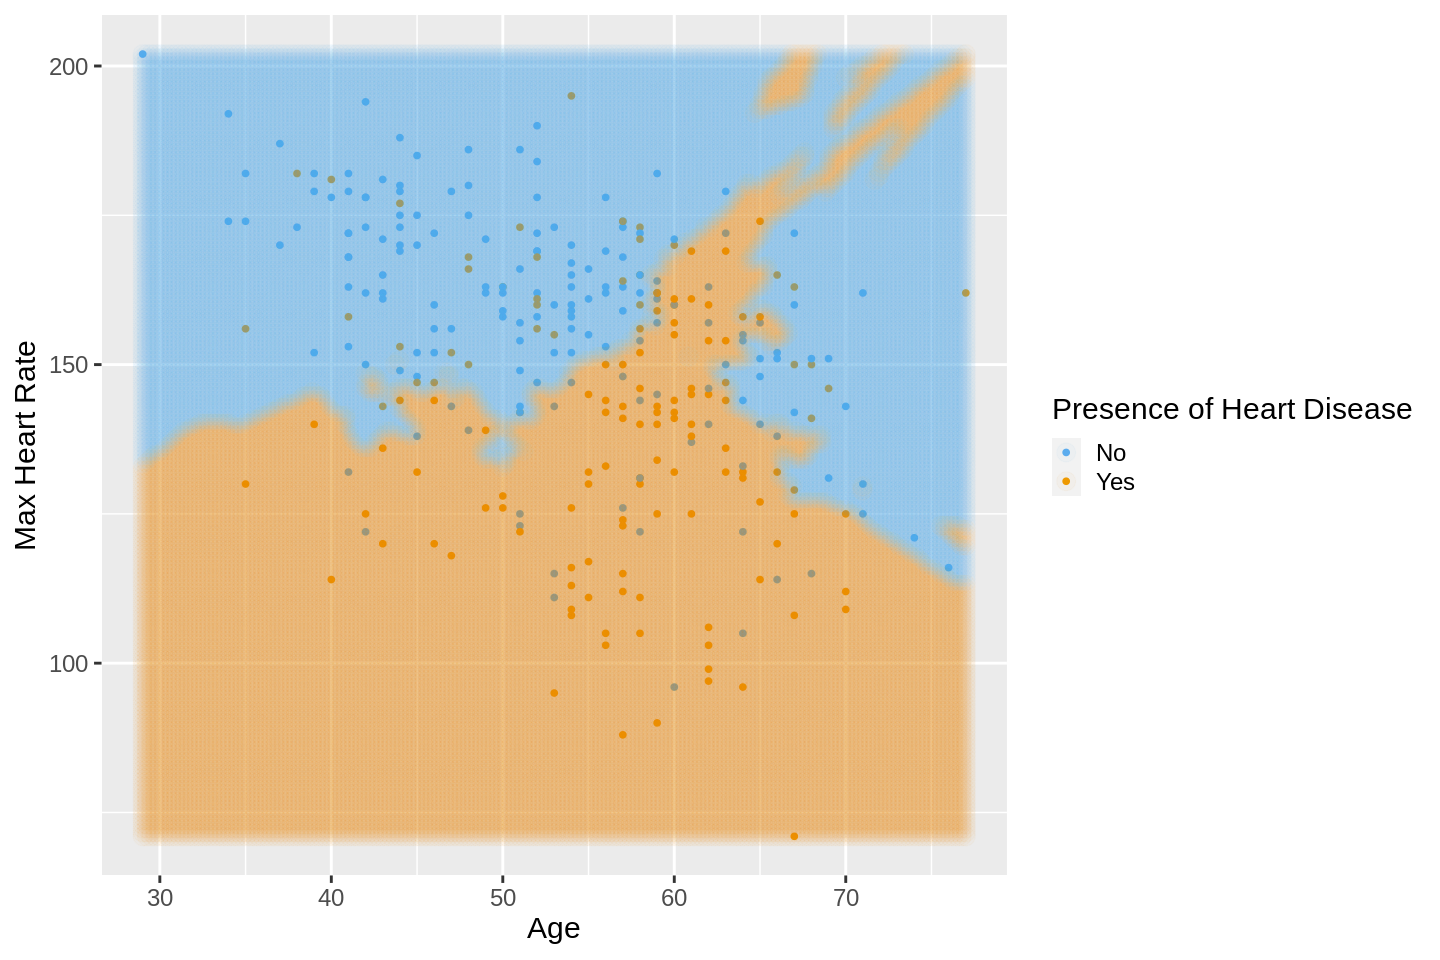

In [22]:
# Prediction results scatterplot
x_grid <- seq(min(heart_data$age), max(heart_data$age), length.out = 200)
y_grid <- seq(min(heart_data$max_heart_rate), max(heart_data$max_heart_rate), length.out = 200)
xy_grid <- as_tibble(expand.grid(age = x_grid, max_heart_rate = y_grid))
knn_pred_grid <- predict(knn_fit, xy_grid)
prediction_table <- bind_cols(knn_pred_grid, xy_grid)
options(repr.plot.width = 12, repr.plot.height = 8)

pred_plot <- ggplot() +
    geom_point(data = heart_data, mapping = aes(x = age, y = max_heart_rate, color = heart_disease), alpha = 1.5) +
    geom_point(data = prediction_table, mapping = aes(x = age, y = max_heart_rate, color = .pred_class), alpha = 0.03, size = 5) +
    labs(color = "Presence of Heart Disease", x = "Age", y = "Max Heart Rate") +
    scale_color_manual(labels = c("No", "Yes"), values = c("steelblue2", "orange2"))
pred_plot

## Discussion

#### Expected outcomes
* <b> Age </b> - heart diseases are expected to be more common in older people (>65 years) since aging causes changes in the heart and blood vessels. Additionally, in the histogram above that visualize age distribution of patients with and without heart disease, there is higher mean and median age of patients with heart disease than patients without heart disease.
* <b>Maximum heart rate</b> - we expect a weak association between a high maximum heart rate and heart disease since rapid heartbeat is a symptom of coronary artery disease, however, different ages, weights, heights, affect heart rate and what constitutes “rapid heartbeat” which may weaken its relationship with the presence of heart disease. Surprisingly, the histogram above visualizes a lower mean and median maximum heart rate for patients with heart disease compared to patients without. This variable shows unexpected results but may be a useful predictor as there is a significant difference between heart disease positive and negative patients using this predictor.
<br>
<!-- 2. <b>Resting blood pressure</b> - we expect that high blood pressure (>130mm assumed systolic bp) will be positively associated with presence of heart disease since high blood pressure is a risk factor for heart disease. However, the histogram above visualizes only a slightly higher mean and median blood pressure for patients with heart disease compared to patients who do not, indicating that resting blood pressure may not be as valuable a predictor as other variables.3. <b>Cholesterol</b> - we expect that high levels of cholesterol (>240mg/dL) will be positively associated with presence of heart disease since high cholesterol is known to increase risk of heart attacks. However, the histogram above visualizes only slightly higher mean cholesterol levels in patients with heart disease compared to patients without, indicating that resting blood pressure may not be as valuable a predictor as other variables. -->


#### Findings
Using the ggpairs function to compare the differences between patients with heart disease and patients without heart disease in all numerical variables, we discovered that maximum heart rate and age had the most significant gap between values associated with a presence of heart disease and values associated with an absence of heart disease. To optimize our model's accuracy, we reduced the amount of predictor variables in our predictive question which used to include four predictor variables (age, max heart rate, cholesterol and blood sugar level) to only include age and maximum heart rate as the predictors. Mapping the predicted present and absent heart disease cases using our selected predictors, we find that patients aged 30-60 with a maximum heart rate of less than about 150 BPM are predicted to have heart disease. On the other hand, in ages 65-75, the threshold for heart disease becomes lower as those with a maximum heart rate of under 120 are predicted to have heart disease. The accuracy of the model was about 73%. The data set has a proportion of about 55% no observations and 45% yes observations, so a baseline model that always picks "no" would be correct about 55% of the time. In this way, an improvement to 73% is significant. However, our model still contains a relatively high margin of error. If this model were to be used practically it should only advise patients whether they are likely to have heart disease based on their age and maximum heart rate as it is not accurate enough to make a reliable diagnosis.
<br><br>
<b>What impact could such findings have?</b> <br>
Predictions made by the indicators age and maximum heart rate can greatly reduce the chance of asymptomatic heart diseases going undiagnosed as these indicators are more conveniently measured than direct, elaborate testings on the heart which are usually only considered after the patient has experienced discomfort.
<br><br>
<b>What future questions could this lead to?</b><br>
This analysis exposed many interesting questions about the impact different health indicators have on heart disease. The predicted presence of heart disease visualization shows some unique features we would not have predicted. For example, from age 60-65 presence of heart disease increases along the range of maximum heart rate values then decreases past the age of 65. Additionally, our visualization indicates that lower maximum heart rate correlate with a larger presence of heart disease. Future analyses may provide explanations as to why some of these relationships exist.
<!-- Which of these predictors has the highest impact on the presence of heart disease?
Do some of these predictors facilitate asymptomatic heart disease more than symptomatic ones? -->

## Bibliography
Andras Janosi, M.D., William Steinbrunn,.M.D., Matthias Pfisterer,.M.D., & Robert Detrano, .M.D, Ph.D. (1988, July 1). UCI Machine Learning Repository: Heart Disease Data Set [Dataset]. https://archive.ics.uci.edu/ml/datasets/heart+disease
<br><br>
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science
<br><br>
“Heart Health and Aging.” National Institute on Aging, U.S. Department of Health and Human Services, 1 June 2018, https://www.nia.nih.gov/health/heart-health-and-aging.
<br><br>
Perret-Guillaume C, Joly L, Benetos A. Heart rate as a risk factor for cardiovascular disease. Prog Cardiovasc Dis. 2009 Jul-Aug;52(1):6-10. doi: 10.1016/j.pcad.2009.05.003. PMID: 19615487.
<br><br>
“Prevention of Heart Diseases and Conditions.” Canada.ca, Public Health Agency of Canada, 10 Mar. 2017, https://www.canada.ca/en/public-health/services/diseases/heart-health/heart-diseases-conditions/prevention-heart-diseases-conditions.html.